Цель:

В этом домашнем задании будет заниматься очень интересными прогнозами, которые вполне могут быть полезны для организации работы метро - попробуем построить 
модель, которая предсказывает, сколько пассажиров будут им пользоваться в ближайшее время.

Описание/Пошаговая инструкция выполнения домашнего задания:
Подготовка

Скачиваем данные по загруженности метро вот отсюда https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

Проводим базовый EDA, вам понадобятся только 4 столбца датасета - traffic_volume (наша целевая переменная), date_time, holiday (является ли день некоторым праздником) и temp (температура воздуха)

По результатам EDA убеждаемся, что в этом временном ряду во-первых, есть дубликаты, а во-вторых, нарушена равномерность временных интервалов, т.е. не все значения отстоят друг от друга на 1 час - дубликаты удаляем, а временные интервалы выравниваем и заполняем пропуски при помощи линейной интерполяции (подсказка - в этом вам помогут функции pd.date_range, и interpolate, пример можно найти здесь - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html) Моделирование Теперь, когда ряд выглядит более-менее адекватно, настало время прогнозировать. Нашей целью будет построить модель, которая способна прогнозировать загрузку метро на ближайшую неделю (т.е, так как данные у нас дневные, модель должна предсказывать на 24*7 точек вперёд).

Отложите последние две недели в датасете для тестирования вашей модели - на этих данных вы будете проверять финальное качество всех моделек
Теперь у вас осталось еще много-много наблюдений во временном ряду, исходя из графиков, трендов и т.д., попробуйте предположить, какие исторические данные действительно будут релевантны для прогнозов текущих значений, возможно, предыдущие три года уже не так сильно влияют на следующую неделю и можно значительную часть данных просто выкинуть

Генерируем дополнительные признаки из индекса, особенно нужен день недели и час дня

Строим baseline прогноз - по тем данным, которые вы решили оставить для обучения модели, посчитайте средние значения по часам и по дням (вам поможет data.groupby(["weekday", "hour"])["traffic_volume"].mean() и используйте эти значения в качестве прогноза на отложенную выборку - посчитайте метрики качества, которые вы посчитаете нужными

А теперь свободное творчество - попробуйте построить разные модели, которые мы с вами разбирали, и побить качество базового прогноза. Несколько советов
для SARIMA модели имеет смысл указать недельную сезонность (т.е. 24*7), чтобы она учла падения по выходным
попробуйте использовать температуру воздуха, как признак, в этом случае можно отдельно спрогнозировать температуру (например, используя SARIMA), а затем воспользоваться этими предсказаниями, когда будете делать прогноз для отложенной части выборки

Наконец, когда вы подберете модель, устраивающую вас по качеству на отложенной выборке, используйте эту выборку для построения прогноза на следующую неделю и попробуйте построить доверительные интервалы для этого прогноза


In [5]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.api import tsa
import statsmodels.api as sm
import statsmodels.tsa.api as smt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')

## EDA

In [7]:
df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


In [ ]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


traffic_volume (целевая переменная), 

date_time, 

temp (температура воздуха)

In [8]:
df = df.loc[:, ['date_time', 'temp', 'traffic_volume']]

In [ ]:
df['holiday'].value_counts()

None                         48143
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: holiday, dtype: int64

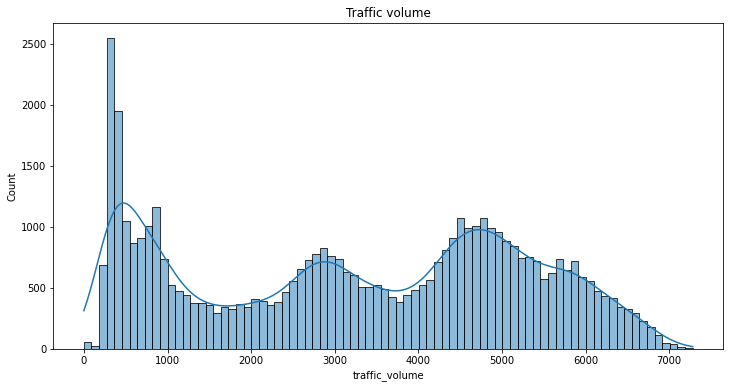

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(df['traffic_volume'], bins=80, ax=ax, kde=True)
ax.set_facecolor('white')
ax.set_title('Traffic volume');

Заметно сильное падение в 0. Возможно выброс.

Также выделяются два пика, которые, возможно, приходятся на зимний и летний период соотвественно 

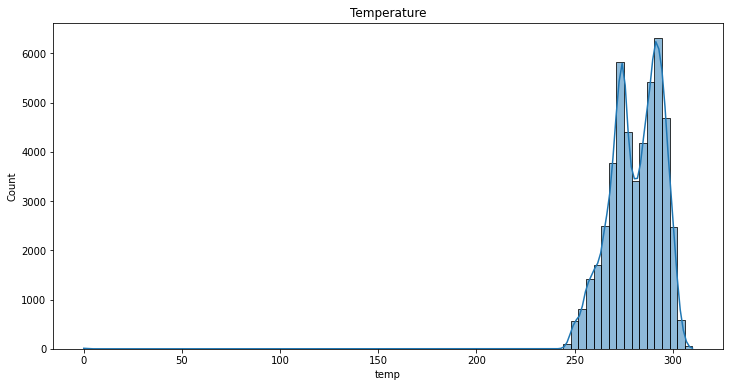

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.histplot(df['temp'], bins=80, ax=ax, kde=True)
ax.set_facecolor('white')
ax.set_title('Temperature');

In [ ]:
df.duplicated().value_counts()

False    40653
True      7551
dtype: int64

In [ ]:
df.loc[df.duplicated() == True, :]

,date_time,holiday,temp,traffic_volume
179,2012-10-10 07:00:00,None,281.25,6793
181,2012-10-10 08:00:00,None,280.10,6283
183,2012-10-10 09:00:00,None,279.61,5680
270,2012-10-14 09:00:00,None,282.43,2685
271,2012-10-14 09:00:00,None,282.43,2685
...,...,...,...,...
48072,2018-09-25 16:00:00,None,284.25,6597
48112,2018-09-27 07:00:00,None,285.17,6589
48173,2018-09-29 19:00:00,None,280.68,3818
48193,2018-09-30 14:00:00,None,283.48,4380


In [9]:
df = df.drop_duplicates(subset=['date_time'],keep='first')

In [10]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [11]:
min_date = df['date_time'].min()
max_date = df['date_time'].max()

dates = pd.date_range(start=min_date, end=max_date, freq='1H')
df_dates = pd.DataFrame({'date_time': dates})

In [12]:
df = pd.merge(df_dates, df, how='left', on='date_time')

In [14]:
df

,date_time,temp,traffic_volume
0,2012-10-02 09:00:00,288.28,5545.0
1,2012-10-02 10:00:00,289.36,4516.0
2,2012-10-02 11:00:00,289.58,4767.0
3,2012-10-02 12:00:00,290.13,5026.0
4,2012-10-02 13:00:00,291.14,4918.0
...,...,...,...
52546,2018-09-30 19:00:00,283.45,3543.0
52547,2018-09-30 20:00:00,282.76,2781.0
52548,2018-09-30 21:00:00,282.73,2159.0
52549,2018-09-30 22:00:00,282.09,1450.0


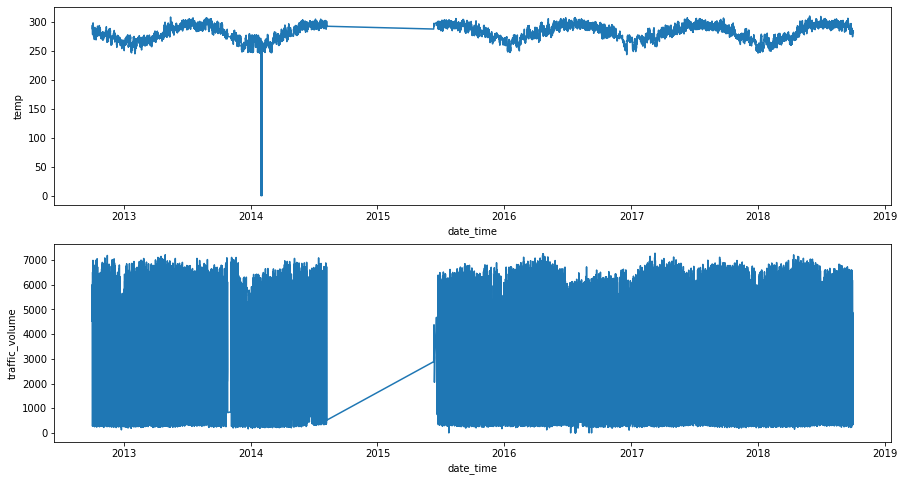

In [16]:
f, ax = plt.subplots(2, 1, figsize=(15, 8))

sns.lineplot(data=df, x = 'date_time', y = 'temp', ax=ax[0])
sns.lineplot(data=df, x = 'date_time', y = 'traffic_volume', ax=ax[1])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52629 entries, 0 to 52628
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date_time       52629 non-null  datetime64[ns]
 1   temp            40653 non-null  float64       
 2   traffic_volume  40653 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 3.6 MB


In [13]:
df.loc[:, ['temp', 'traffic_volume']] = df.loc[:, ['temp', 'traffic_volume']].interpolate(method='linear', axis=0)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52629 entries, 0 to 52628
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date_time       52629 non-null  datetime64[ns]
 1   temp            52629 non-null  float64       
 2   traffic_volume  52629 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 3.6 MB


Видно, что есть огромный провал между серединой 2014 года и серединой 2015 года, также есть огромный провал в 2014 году. Кажется, что не будет страшно, если взять данные с начаа 2018 года.

In [14]:
df = df.loc[df['date_time'] >= datetime.datetime(2018, 1, 1), :]

In [15]:
df['month'] = df['date_time'].dt.month
df['hour'] = df['date_time'].dt.hour
df['weekday'] = df['date_time'].dt.dayofweek

На графиках по Traffic volume заметна недельная периодичность(пики снижаются, как раз приходятся на выходные)

У температуры заметен суточный цикл

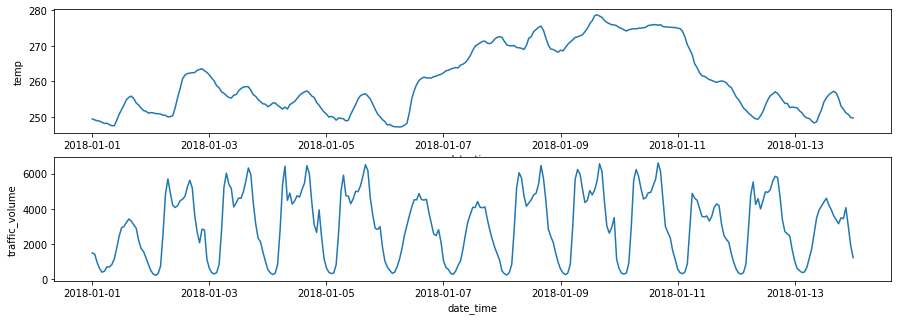

In [ ]:
f, axs = plt.subplots(2, 1, figsize=(15, 5))

graph = df.loc[(df['date_time'] >= datetime.datetime(2018, 1, 1)) & 
               (df['date_time'] <= datetime.datetime(2018, 1, 14)), :].copy()
sns.lineplot(data=graph, x = 'date_time', y = 'temp', ax=axs[0])
sns.lineplot(data=graph, x = 'date_time', y = 'traffic_volume', ax=axs[1])

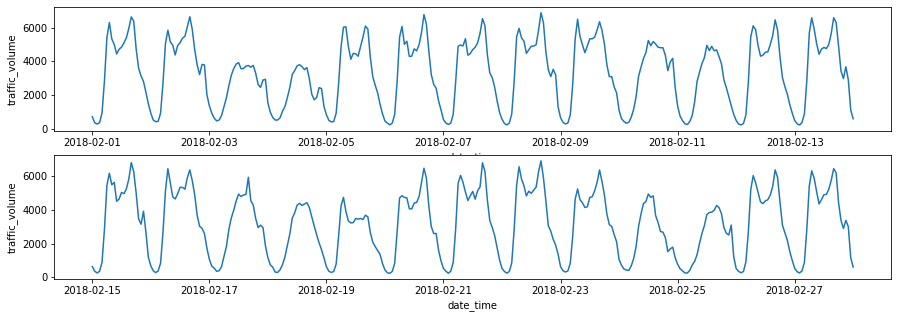

In [ ]:
f, axs = plt.subplots(2, 1, figsize=(15, 5))

graph1 = df.loc[(df['date_time'] >= datetime.datetime(2018, 2, 1)) & 
               (df['date_time'] <= datetime.datetime(2018, 2, 14)), :].copy()
graph2 = df.loc[(df['date_time'] >= datetime.datetime(2018, 2, 15)) & 
               (df['date_time'] <= datetime.datetime(2018, 2, 28)), :].copy()
sns.lineplot(data=graph1, x = 'date_time', y = 'traffic_volume', ax=axs[0])
sns.lineplot(data=graph2, x = 'date_time', y = 'traffic_volume', ax=axs[1])

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
    Plot time series, its ACF and PACF, calculate Dickey–Fuller test
    :param y:     Timeseries
    :param lags:  How many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method="ols")
        plt.tight_layout()

По графикам автокорелляции видно, что traffic volume имеет суточную цикличность.

На первом граффике максимум приходится на 24. На втором графике максимум приходится примерно на 170, что почти равно 24*7.

Также можно пронаблюдать суточную цикличность и у temp

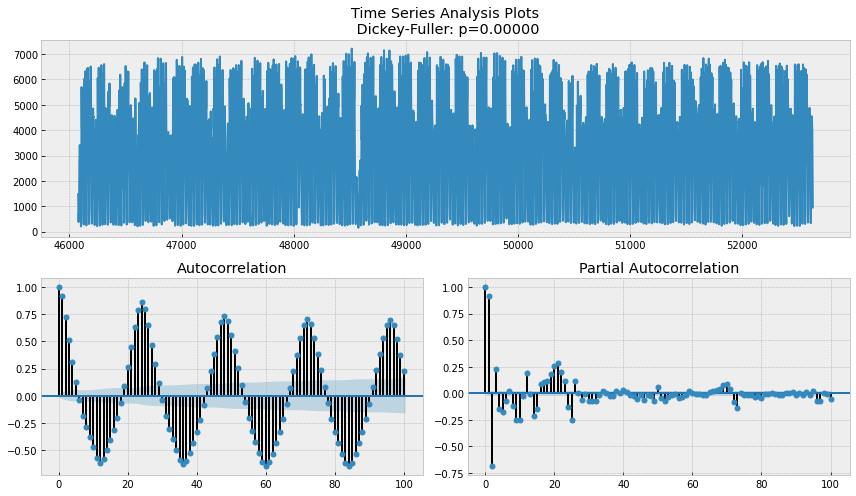

In [ ]:
tsplot(df.loc[:,'traffic_volume'], lags=100)

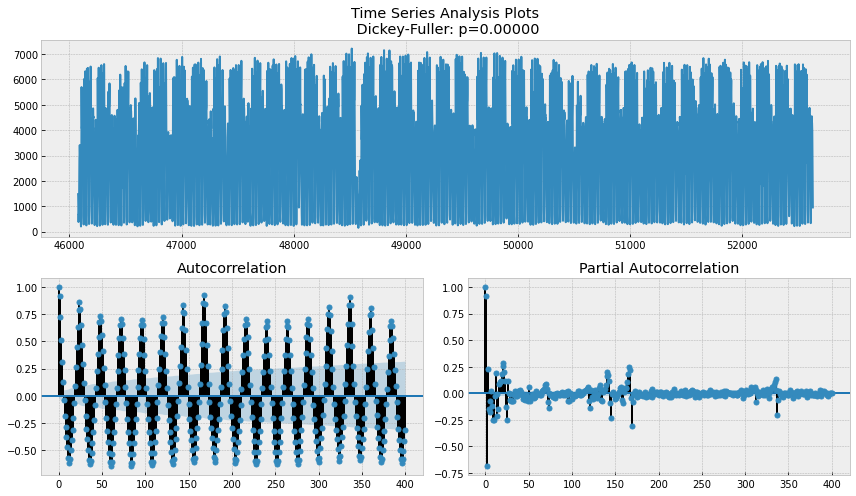

In [ ]:
tsplot(df.loc[:,'traffic_volume'], lags=400)

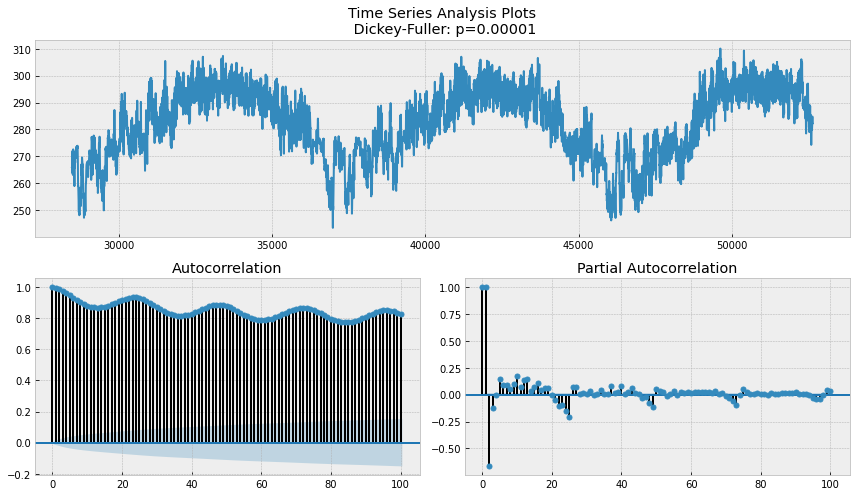

In [ ]:
tsplot(df.loc[:,'temp'], lags=100)

In [16]:
df['cos_time'] = np.sin(2*np.pi*df['date_time'].dt.hour/24)
df['sin_time'] = np.cos(2*np.pi*df['date_time'].dt.hour/24)

In [17]:
df = df.reset_index()

## Baseline

In [23]:
split_index = 24*7*2
df_train = df.iloc[:split_index,:]
df_test = df.iloc[len(df) -split_index:,:]

In [26]:
y_train = df_train.groupby(['weekday', 'hour'])['traffic_volume'].mean().reset_index()
y_train.columns = ['weekday', 'hour', 'pred']
#y_test = df_test.groupby(['weekday', 'hour'])['traffic_volume'].mean().reset_index()

In [27]:
y_pred = pd.merge(df_test, y_train, how='left', on=['weekday', 'hour'])['pred']

In [28]:
print("MAPE: ", sklearn.metrics.mean_absolute_percentage_error(df_test['traffic_volume'],y_pred ))
print("RMSE: ", np.sqrt(sklearn.metrics.mean_squared_error(df_test['traffic_volume'],y_pred)))

MAPE:  0.15880700529399872
RMSE:  682.4815255654144


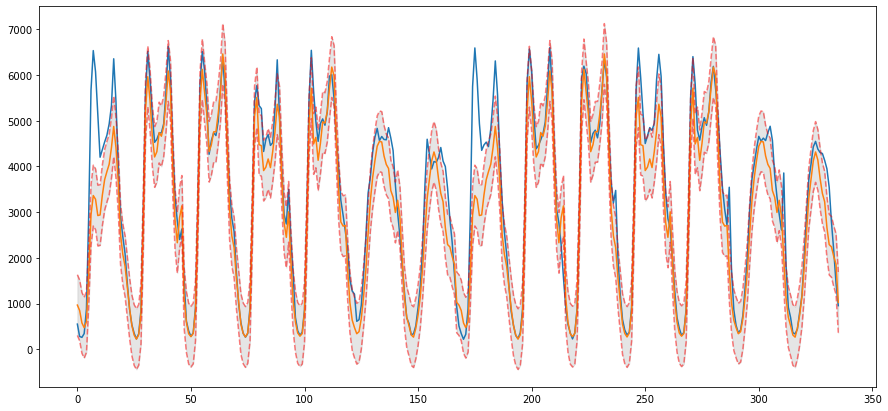

In [31]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)

mae = df_train['traffic_volume'].mean() * (-1)
deviation = df_train['traffic_volume'].std()
scale = 1.96
lower = y_pred - (mae + scale * deviation)
upper = y_pred + (mae + scale * deviation)

ax.plot(df_test['traffic_volume'].values)
ax.plot(y_pred.values)
ax.plot(lower.values, "r--", label="Up/Low confidence", alpha=0.5)
ax.plot(upper.values, "r--", alpha=0.5)


ax.fill_between(x=upper.index, y1=upper.values,
                      y2=lower.values, alpha=0.2, color = "grey")

## Time Series Models

### Sarimax

In [18]:
def plotSARIMA(series, model, n_steps, s=24, d=1, plot_intervals=True, alpha=0.2):
    """
    Plots model vs predicted values
    :param series:   Dataset with timeseries
    :type series:     pd.DataFrame
    :param model:    Fitted SARIMA model
    :type model:      sm.tsa.statespace.SARIMAX
    :param n_steps:  Number of steps to predict in the future
    :type n_steps:    int
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.get_forecast(steps=n_steps)
    model_predictions = data['arima_model'].append(forecast.predicted_mean)
    # calculate error, again having shifted on s+d steps from the beginning
    error = sklearn.metrics.mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    
    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))    
    
    plt.plot(model_predictions, color='r', label="model")
    plt.plot(data['actual'], label="actual")
    
    if plot_intervals:
        intervals = forecast.conf_int(alpha=alpha)
        intervals.columns=['lower', 'upper']
        plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(intervals['upper'], "r--", alpha=0.5)
        plt.fill_between(x=intervals.index, y1=intervals['upper'],
                         y2=intervals['lower'], alpha=0.2, color = "grey")
    
    plt.legend()
    plt.grid(True)

In [19]:
split_index = 24*7*2
df_train = df.iloc[:-split_index,:]
df_test = df.iloc[len(df)-split_index:,:]

In [20]:
df.iloc[-split_index:,:]

,index,date_time,temp,traffic_volume,month,hour,weekday,cos_time,sin_time
6216,52215,2018-09-17 00:00:00,296.58,550.0,9,0,0,0.000000,1.000000
6217,52216,2018-09-17 01:00:00,296.19,280.0,9,1,0,0.258819,0.965926
6218,52217,2018-09-17 02:00:00,295.82,260.0,9,2,0,0.500000,0.866025
6219,52218,2018-09-17 03:00:00,295.83,344.0,9,3,0,0.707107,0.707107
6220,52219,2018-09-17 04:00:00,295.68,880.0,9,4,0,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...
6547,52546,2018-09-30 19:00:00,283.45,3543.0,9,19,6,-0.965926,0.258819
6548,52547,2018-09-30 20:00:00,282.76,2781.0,9,20,6,-0.866025,0.500000
6549,52548,2018-09-30 21:00:00,282.73,2159.0,9,21,6,-0.707107,0.707107
6550,52549,2018-09-30 22:00:00,282.09,1450.0,9,22,6,-0.500000,0.866025


In [21]:
from itertools import product
p=1
q=1
d = 1 
D = 1
Q = 0
P =  1
s = 24*7


In [22]:
df.loc[len(df)-split_index-24*7*4:len(df)-split_index,:]

,index,date_time,temp,traffic_volume,month,hour,weekday,cos_time,sin_time
5544,51543,2018-08-20 00:00:00,296.22,922.0,8,0,0,0.000000,1.000000
5545,51544,2018-08-20 01:00:00,295.62,473.0,8,1,0,0.258819,0.965926
5546,51545,2018-08-20 02:00:00,294.82,346.0,8,2,0,0.500000,0.866025
5547,51546,2018-08-20 03:00:00,294.69,369.0,8,3,0,0.707107,0.707107
5548,51547,2018-08-20 04:00:00,294.49,941.0,8,4,0,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...
6212,52211,2018-09-16 20:00:00,300.78,3092.0,9,20,6,-0.866025,0.500000
6213,52212,2018-09-16 21:00:00,298.90,2623.0,9,21,6,-0.707107,0.707107
6214,52213,2018-09-16 22:00:00,297.85,1725.0,9,22,6,-0.500000,0.866025
6215,52214,2018-09-16 23:00:00,297.44,1088.0,9,23,6,-0.258819,0.965926


In [23]:
model = sm.tsa.statespace.SARIMAX(df.loc[len(df)-split_index-24*7*4:len(df)-split_index, 'traffic_volume'],
                                  order=(p, d, q),
                                  seasonal_order=(P, D, Q, s)).fit(disp=-1)

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                 
===========================================================================================
Dep. Variable:                      traffic_volume   No. Observations:                  673
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 168)   Log Likelihood               -3643.373
Date:                             Tue, 03 May 2022   AIC                           7294.745
Time:                                     08:12:55   BIC                           7311.635
Sample:                                          0   HQIC                          7301.371
                                             - 673                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9993      0.014    -72.445      0.000      -1.026      -0.972
ma.L1          0.9968      0.026     38.608      0.000       0.946       1.047
ar.S.L168     -0.5714      0.029    -19.469      0.000      -0.629      -0.514
sigma2       9.95e+04   2632.778     37.791      0.000    9.43e+04    1.05e+05
===================================================================================
Ljung-Box (Q):                       86.93   Jarque-Bera (JB):              2422.52
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.79   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
forecast_length = 24

traffic_forecast = model.get_forecast(steps=forecast_length).predicted_mean
print("MAPE: ", sklearn.metrics.mean_absolute_percentage_error(df.loc[len(df)-forecast_length:, 'traffic_volume'], traffic_forecast))
print("RMSE: ", np.sqrt(sklearn.metrics.mean_squared_error(df.loc[len(df)-forecast_length:, 'traffic_volume'], traffic_forecast)))

MAPE:  0.853213739557138
RMSE:  1134.6824310806087


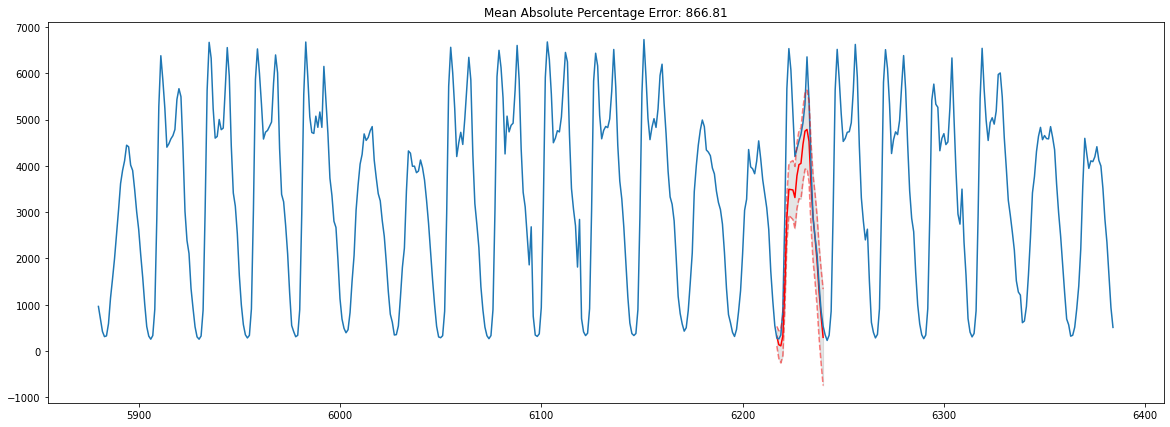

In [26]:
error = sklearn.metrics.mean_absolute_error(df.loc[len(df)-forecast_length:, 'traffic_volume'], traffic_forecast)
data = df.copy()
data = data.loc[len(df)-split_index*2:len(df)-split_index+s,  : ]
plt.figure(figsize=(20, 7))
plt.title("Mean Absolute Percentage Error: {0:.2f}".format(error))    

plt.plot( traffic_forecast, color='r', label="model")
plt.plot( data['traffic_volume'], label="actual")

forecast = model.get_forecast(steps=forecast_length)
intervals = forecast.conf_int(alpha=0.5)
intervals.columns=['lower', 'upper']
plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
plt.plot(intervals['upper'], "r--", alpha=0.5)
plt.fill_between(x=intervals.index, y1=intervals['upper'],
                      y2=intervals['lower'], alpha=0.2, color = "grey")

In [ ]:
forecast_length = 72

traffic_forecast = model.get_forecast(steps=forecast_length).predicted_mean
print("MAPE: ", sklearn.metrics.mean_absolute_percentage_error(df.loc[len(df)-forecast_length:, 'traffic_volume'], traffic_forecast))
print("RMSE: ", np.sqrt(sklearn.metrics.mean_squared_error(df.loc[len(df)-forecast_length:, 'traffic_volume'], traffic_forecast)))

In [ ]:
error = sklearn.metrics.mean_absolute_error(df.loc[len(df)-forecast_length:, 'traffic_volume'], traffic_forecast)
data = df.copy()
data = data.loc[len(df)-split_index*2:len(df)-split_index+s,  : ]
plt.figure(figsize=(20, 7))
plt.title("Mean Absolute Percentage Error: {0:.2f}".format(error))    

plt.plot( traffic_forecast, color='r', label="model")
plt.plot( data['traffic_volume'], label="actual")

forecast = model.get_forecast(steps=forecast_length)
intervals = forecast.conf_int(alpha=0.5)
intervals.columns=['lower', 'upper']
plt.plot(intervals['lower'], "r--", alpha=0.5, label = "Up/Low confidence")
plt.plot(intervals['upper'], "r--", alpha=0.5)
plt.fill_between(x=intervals.index, y1=intervals['upper'],
                      y2=intervals['lower'], alpha=0.2, color = "grey")

Видно, что модель не удалось уловить цикличность. Все предсказанный период больше похож на те значения, что наблюдаются в выходные дни

In [72]:
forecast_length = 24*7*2

traffic_forecast = model.get_forecast(steps=forecast_length).predicted_mean
print("MAPE: ", sklearn.metrics.mean_absolute_percentage_error(df.loc[len(df)-forecast_length:, 'traffic_volume'], traffic_forecast))
print("RMSE: ", np.sqrt(sklearn.metrics.mean_squared_error(df.loc[len(df)-forecast_length:, 'traffic_volume'], traffic_forecast)))

MAPE:  0.28285473592691324
RMSE:  1426.9235703124255


### Prophet

In [ ]:
from fbprophet import Prophet

In [ ]:
split_index = 24*7*2
df_train = df.loc[:len(df)-split_index,['date_time', 'traffic_volume']].copy()
df_test = df.loc[len(df)-split_index:,['date_time', 'traffic_volume']].copy()

In [ ]:
df_train

,ds,y
0,2018-01-01 00:00:00,1478.0
1,2018-01-01 01:00:00,1408.0
2,2018-01-01 02:00:00,931.0
3,2018-01-01 03:00:00,585.0
4,2018-01-01 04:00:00,381.0
...,...,...
6212,2018-09-16 20:00:00,3092.0
6213,2018-09-16 21:00:00,2623.0
6214,2018-09-16 22:00:00,1725.0
6215,2018-09-16 23:00:00,1088.0


In [ ]:
df_train.columns = ['ds', 'y']
df_test.columns = ['ds', 'y']

In [ ]:
ph_model = Prophet(yearly_seasonality=False,
                   weekly_seasonality=True,
                  daily_seasonality=True )
ph_model.fit(df_train)

pred = ph_model.make_future_dataframe(periods=split_index, freq='H')
pred

,ds
0,2018-01-01 00:00:00
1,2018-01-01 01:00:00
2,2018-01-01 02:00:00
3,2018-01-01 03:00:00
4,2018-01-01 04:00:00
...,...
6548,2018-09-30 20:00:00
6549,2018-09-30 21:00:00
6550,2018-09-30 22:00:00
6551,2018-09-30 23:00:00


In [ ]:
forecast = ph_model.predict(pred)

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01 00:00:00,2832.171758,-1019.275546,1114.147814,2832.171758,2832.171758,-2803.321895,-2803.321895,-2803.321895,-2188.691780,...,-357.091679,-357.091679,-357.091679,-257.538435,-257.538435,-257.538435,0.0,0.0,0.0,28.849863
1,2018-01-01 01:00:00,2832.168342,-1706.484281,523.277425,2832.168342,2832.168342,-3445.051406,-3445.051406,-3445.051406,-2868.525747,...,-324.782835,-324.782835,-324.782835,-251.742824,-251.742824,-251.742824,0.0,0.0,0.0,-612.883064
2,2018-01-01 02:00:00,2832.164926,-2121.526558,102.235747,2832.164926,2832.164926,-3829.596905,-3829.596905,-3829.596905,-3290.533158,...,-293.082108,-293.082108,-293.082108,-245.981639,-245.981639,-245.981639,0.0,0.0,0.0,-997.431979
3,2018-01-01 03:00:00,2832.161510,-1858.546807,303.264241,2832.161510,2832.161510,-3592.066868,-3592.066868,-3592.066868,-3089.682824,...,-262.129170,-262.129170,-262.129170,-240.254873,-240.254873,-240.254873,0.0,0.0,0.0,-759.905358
4,2018-01-01 04:00:00,2832.158094,-851.981308,1330.232623,2832.158094,2832.158094,-2639.739266,-2639.739266,-2639.739266,-2173.127161,...,-232.049590,-232.049590,-232.049590,-234.562515,-234.562515,-234.562515,0.0,0.0,0.0,192.418828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6548,2018-09-30 20:00:00,2809.800849,1299.272593,3417.743860,2809.800820,2809.800877,-394.274322,-394.274322,-394.274322,-396.964934,...,-489.172237,-489.172237,-489.172237,491.862849,491.862849,491.862849,0.0,0.0,0.0,2415.526527
6549,2018-09-30 21:00:00,2809.797432,1010.640715,3068.823185,2809.797404,2809.797460,-859.809697,-859.809697,-859.809697,-890.978341,...,-456.077201,-456.077201,-456.077201,487.245846,487.245846,487.245846,0.0,0.0,0.0,1949.987736
6550,2018-09-30 22:00:00,2809.794016,588.427666,2805.076427,2809.793987,2809.794044,-1161.821963,-1161.821963,-1161.821963,-1221.509501,...,-422.909642,-422.909642,-422.909642,482.597180,482.597180,482.597180,0.0,0.0,0.0,1647.972053
6551,2018-09-30 23:00:00,2809.790599,239.543732,2340.367407,2809.790570,2809.790627,-1515.996202,-1515.996202,-1515.996202,-1604.057378,...,-389.855690,-389.855690,-389.855690,477.916866,477.916866,477.916866,0.0,0.0,0.0,1293.794397


In [ ]:
y_pred = forecast.loc[len(forecast)-split_index:, 'yhat']
y_true = df_test.loc[:, 'y']
print("MAPE: ", sklearn.metrics.mean_absolute_percentage_error(y_true, y_pred))
print("RMSE: ", np.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred)))

MAPE:  0.6058348715584675
RMSE:  1029.5489008974075


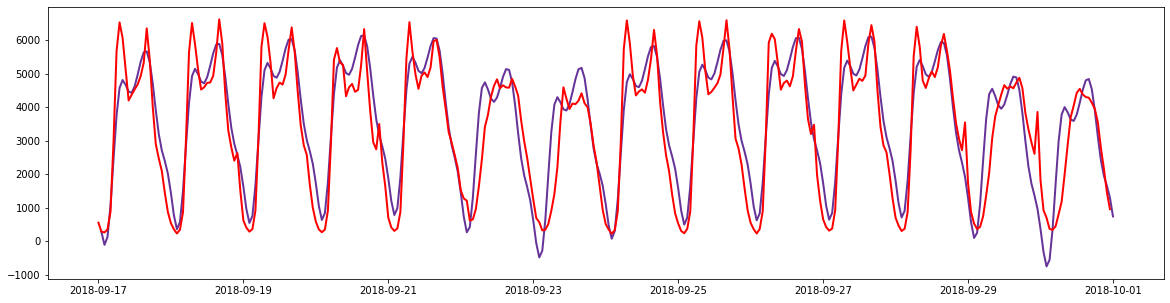

In [71]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(
    forecast.loc[len(forecast)-split_index:, 'ds'],
    forecast.loc[len(forecast)-split_index:, 'yhat'], color='rebeccapurple', lw=2
)
ax.plot(
    df_test.loc[:, 'ds'],
    df_test.loc[:, 'y'], color='r', ls='-', lw=2, label='прогноз'
);



# Выводы

Построенный Baseline показал лучший результат(по метрике RMSE) при прогнозе на две недели

Построение модели SARIMAX с сезонностью в 168(24*7) занимает много ресурсов  

Модели Prophet удалось уловить недельную сезонность